# Model selection

In [1]:
%load_ext autoreload
%autoreload 2
import latenta as la
import lacell as lac
import numpy as np

We'll use the same dataset as [before](./1-variables).

In [2]:
import scanpy as sc

adata = la.data.load_myod1()
adata.obs["log_overexpression"] = np.log1p(adata.obs["overexpression"])
adata.var["label"] = adata.var["symbol"]
adata.raw = adata

When we say that a model is statistically significant, what we actually mean is that one model is much more likely to be true than another _simpler_ model. In classical statistical testing these two models are called the alternative hypothesis and the null hypothesis.

While statistical testing is powerful for some models, it often falls short when we try to do anything more complex. If we for example include any cellular latent variables, it becomes impossible to calculate any reasonable p-value. Furthermore, if we want to compare many different models.

One main reason to thus use probabilistic modelling is that it allows us to generalize statistical testing to a technique called model selection. In this way, we can even In a probabilistic setting, the generalization of statistical testing is called model selection.

## Creating the models

We will illustrate model selection with perhaps the simplest model possible: differential expression. We are given an outcome, the overexpression of Myod1, and now want to know which genes are differential. To do this, we will create 3 models: a linear response, a non-linear spline response, and a constant response.

At this stage, the following model-building sections should not hold any mysteries for you and are undocumented. Feel free to try out any extra models, e.g. a {class}`latenta.links.scalar.Switch`, or play with some of the parameters of the spline function to see how this affects the outcome.

In [3]:
models = {}

In [4]:
overexpression = la.Fixed(adata.obs["log_overexpression"], label="overexpression")

### Model 1: Linear

In [5]:
transcriptome = lac.transcriptome.Transcriptome.from_adata(adata)
foldchange = transcriptome.find("foldchange")

foldchange.overexpression = la.links.scalar.Linear(overexpression, a = True, definition=foldchange.value_definition)
foldchange.plot()

  0%|                                                                                                         …

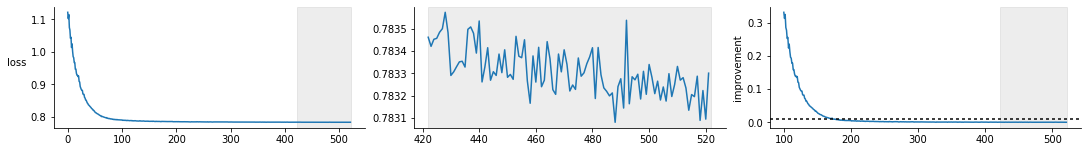

In [6]:
with transcriptome.switch(la.config.device):
    inference = la.infer.svi.SVI(
        transcriptome, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=5e-2)
    )
    trainer = la.infer.trainer.Trainer(inference)
    trace = trainer.train(10000)
    trace.plot();

In [7]:
transcriptome_observed = la.posterior.vector.VectorObserved(transcriptome)
transcriptome_observed.sample(5)

  0%|          | 0/5 [00:00<?, ?it/s]

In [8]:
overexpression_observed = la.posterior.scalar.ScalarObserved(overexpression)
overexpression_observed.sample(5)

  0%|          | 0/5 [00:00<?, ?it/s]

In [9]:
overexpression_causal = la.posterior.scalar.ScalarVectorCausal(
    overexpression, transcriptome, interpretable = transcriptome.p.mu.expression, observed = overexpression_observed
)
overexpression_causal.sample(10)
overexpression_causal.sample_random(10)
overexpression_causal.observed
overexpression_causal.sample_empirical()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

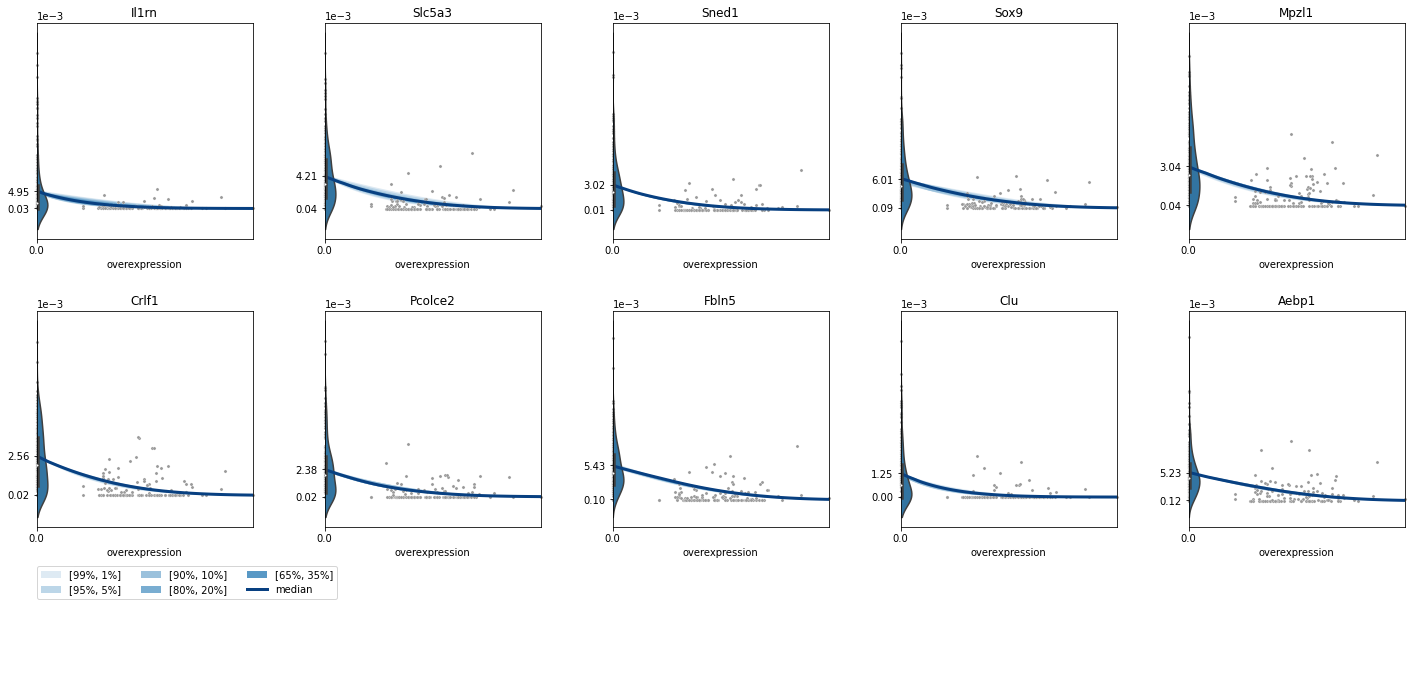

In [10]:
overexpression_causal.plot_features();

In [11]:
models["linear"] = {
    "root":transcriptome,
    "overexpression_causal":overexpression_causal,
    "transcriptome_observed":transcriptome_observed
}

### Model 2: Spline

In [12]:
overexpression = overexpression.reset().clone()

In [13]:
transcriptome = lac.transcriptome.Transcriptome.from_adata(adata)
foldchange = transcriptome.find("foldchange")

foldchange.overexpression = la.links.scalar.Spline(overexpression, definition=foldchange.value_definition)
foldchange.plot()

  0%|                                                                                                         …

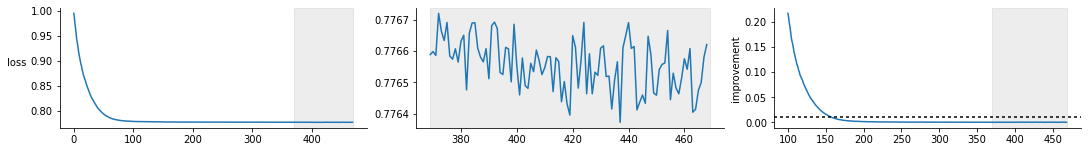

In [14]:
with transcriptome.switch(la.config.device):
    inference = la.infer.svi.SVI(
        transcriptome, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=5e-2)
    )
    trainer = la.infer.trainer.Trainer(inference)
    trace = trainer.train(10000)
    trace.plot();

In [15]:
transcriptome_observed = la.posterior.vector.VectorObserved(transcriptome)
transcriptome_observed.sample(5)

  0%|          | 0/5 [00:00<?, ?it/s]

In [16]:
overexpression_observed = la.posterior.scalar.ScalarObserved(overexpression)
overexpression_observed.sample(5)

  0%|          | 0/5 [00:00<?, ?it/s]

In [17]:
overexpression_causal = la.posterior.scalar.ScalarVectorCausal(
    overexpression, transcriptome, interpretable = transcriptome.p.mu.expression, observed = overexpression_observed
)
overexpression_causal.sample(10)
overexpression_causal.sample_random(10)
overexpression_causal.observed
overexpression_causal.sample_empirical()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

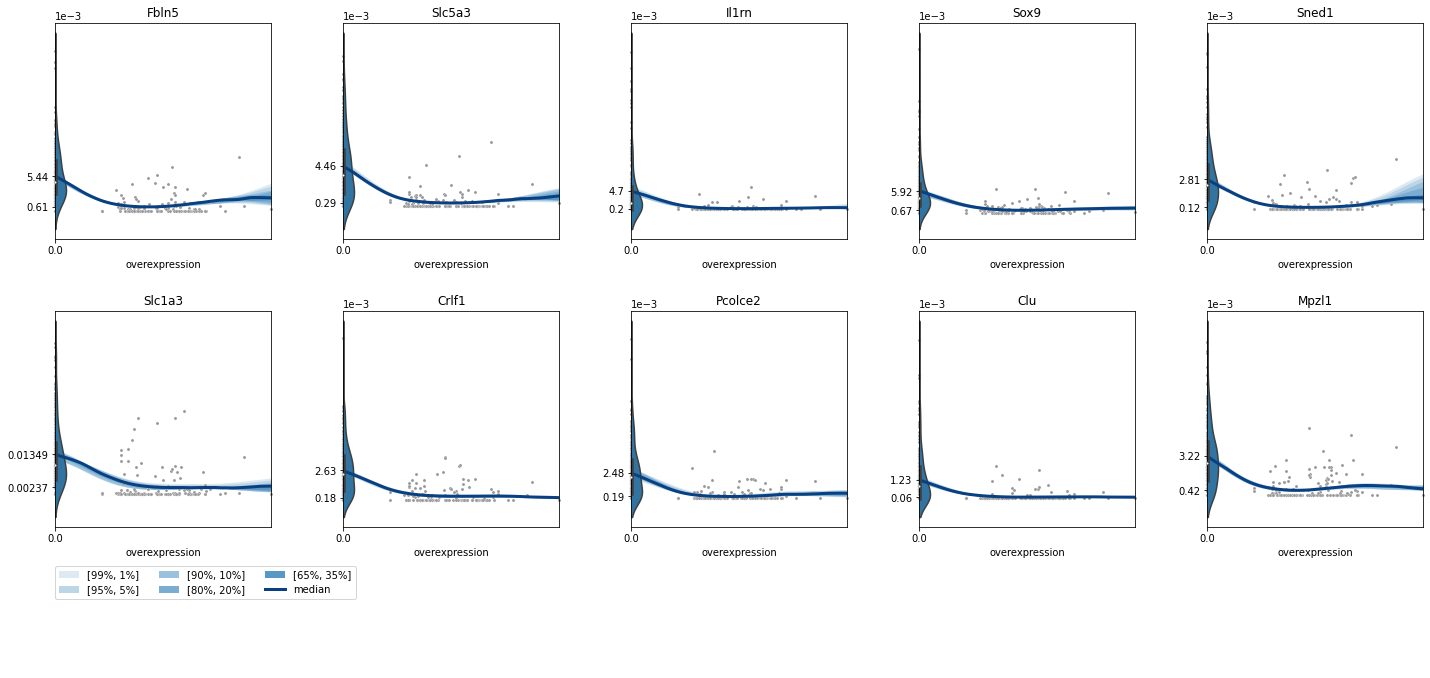

In [18]:
overexpression_causal.plot_features();

In [19]:
models["spline"] = {
    "root":transcriptome,
    "overexpression_causal":overexpression_causal,
    "transcriptome_observed":transcriptome_observed
}

### Model 3: Constant

In [20]:
overexpression = overexpression.reset().clone()

In [21]:
transcriptome = lac.transcriptome.Transcriptome.from_adata(adata)
foldchange = transcriptome.find("foldchange")

foldchange.overexpression = la.links.scalar.Constant(overexpression,definition=foldchange.value_definition)
foldchange.plot()

  0%|                                                                                                         …

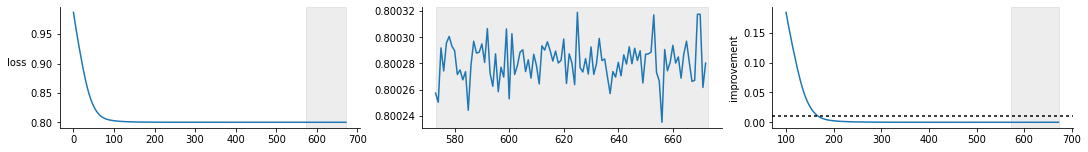

In [22]:
with transcriptome.switch(la.config.device):
    inference = la.infer.svi.SVI(
        transcriptome, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=5e-2)
    )
    trainer = la.infer.trainer.Trainer(inference)
    trace = trainer.train(10000)
    trace.plot();

In [23]:
transcriptome_observed = la.posterior.vector.VectorObserved(transcriptome)
transcriptome_observed.sample(5)

  0%|          | 0/5 [00:00<?, ?it/s]

In [24]:
overexpression_observed = la.posterior.scalar.ScalarObserved(overexpression)
overexpression_observed.sample(5)

  0%|          | 0/5 [00:00<?, ?it/s]

In [25]:
overexpression_causal = la.posterior.scalar.ScalarVectorCausal(
    overexpression, transcriptome, interpretable = transcriptome.p.mu.expression, observed = overexpression_observed
)
overexpression_causal.sample(10)
overexpression_causal.sample_random(10)
overexpression_causal.observed
overexpression_causal.sample_empirical()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

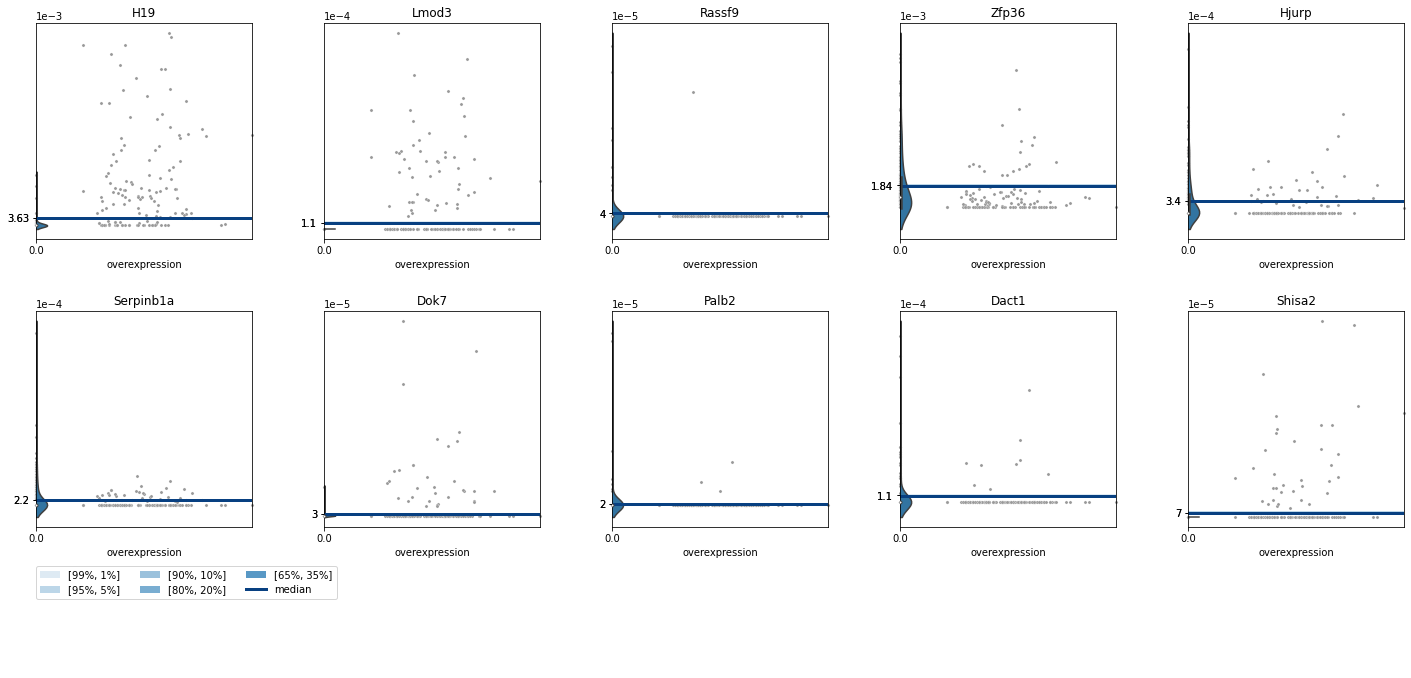

In [26]:
overexpression_causal.plot_features();

In [27]:
models["constant"] = {
    "root":transcriptome,
    "overexpression_causal":overexpression_causal,
    "transcriptome_observed":transcriptome_observed
}

## Model selection

### The Bayes factor

How do we compare models? Because we are creating probabilistic models, it makes sense to also compare models themselves with probabilities. What we want to know is how much more likely one model is over the other. This is mostly driven by how much _evidence_ we have of this, because if we have barely any data, . On the other hand, having a lot of data opens up the possibility to move to ever more complex models with a lot of free parameters.

To calculate the _evidence_ for a model, we therefore have 

It turns out that we actually already have all the information we need to answer this question. Namely, we added priors {citel}

{citel}`kass_bayes_1995`



|    $\textit{BF}$   	|        Strength of evidence        	| $\log_{10} $ 	|   $\log$  	|
|:---------:	|:----------------------------------:	|:------------:	|:------------:	|
|  1 to 3.2 	| Not worth more than a bare mention 	|   0 to 1/2   	|   0 to ~1.1  	|
| 3.2 to 10 	|             Substantial            	|   1/2 to 1   	| ~1.1 to ~2.3 	|
| 10 to 100 	|               Strong               	|    1 to 2    	| ~2.3 to ~4.6 	|
|   > 100   	|              Decisive              	|      > 2     	|    > ~4.6    	|

$\log_{10} bf $

In [28]:
import pandas as pd

In [29]:
model_ids = list(models.keys())

In [30]:
elbo_genes = pd.DataFrame({model_id:model["transcriptome_observed"].elbo_features.to_pandas() for model_id, model in models.items()})
likelihood_genes = pd.DataFrame({model_id:model["transcriptome_observed"].elbo_features.to_pandas() for model_id, model in models.items()})

In [31]:
elbo_genes

,linear,spline,constant
gene,,,
ENSMUSG00000000031,-1032.921491,-1005.135792,-1101.599770
ENSMUSG00000000058,-983.946555,-980.423979,-997.552557
ENSMUSG00000000078,-1759.358052,-1753.946347,-1785.773284
ENSMUSG00000000184,-1711.761474,-1707.994667,-1719.157708
ENSMUSG00000000202,-185.862489,-175.534192,-229.707487
...,...,...,...
ENSMUSG00000117278,-143.266318,-142.459694,-143.434303
ENSMUSG00000117515,-246.612967,-247.237659,-243.985884
ENSMUSG00000117710,-106.765525,-108.867435,-108.623869


### Comparing constant versus all other models

First, we can find generally differentially expressed genes by simply comparing the constant model with all other models:

In [32]:
bfs = (elbo_genes.drop(columns = "constant") - elbo_genes["constant"].values[:, None])
scores = bfs.max(1).rename("bf").to_frame()

<AxesSubplot:ylabel='Density'>

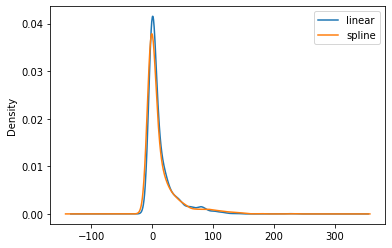

In [33]:
bfs.plot(kind = "kde")

In [34]:
scores["symbol"] = adata.var["symbol"][scores.index]
scores = scores.sort_values("bf", ascending = False)
scores

,bf,symbol
gene,,
ENSMUSG00000028464,232.466302,Tpm2
ENSMUSG00000037062,232.461971,Sh3glb1
ENSMUSG00000091898,178.507856,Tnnc1
ENSMUSG00000026459,174.829564,Myog
ENSMUSG00000061723,152.918837,Tnnt3
...,...,...
ENSMUSG00000021733,-6.153060,Slc4a7
ENSMUSG00000026434,-6.328176,Nucks1
ENSMUSG00000028273,-6.478940,Pdlim5


Text(0.5, 0.98, 'Non-differential genes')

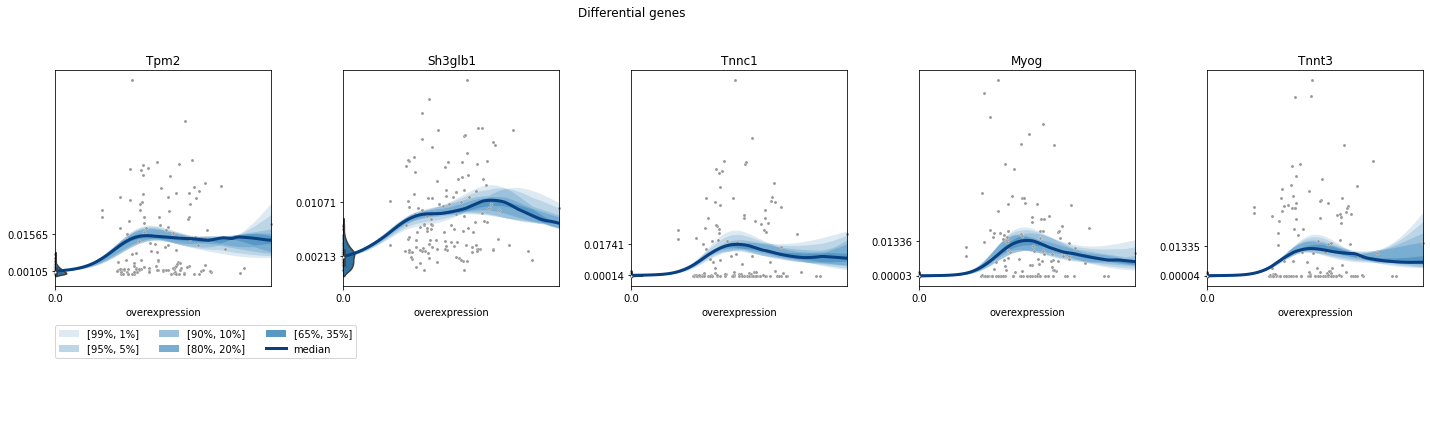

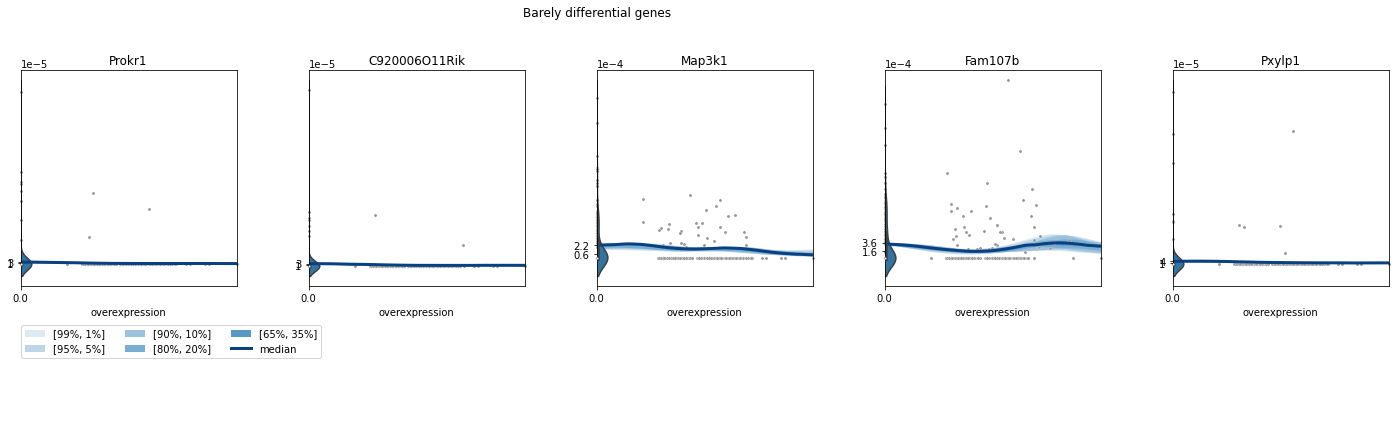

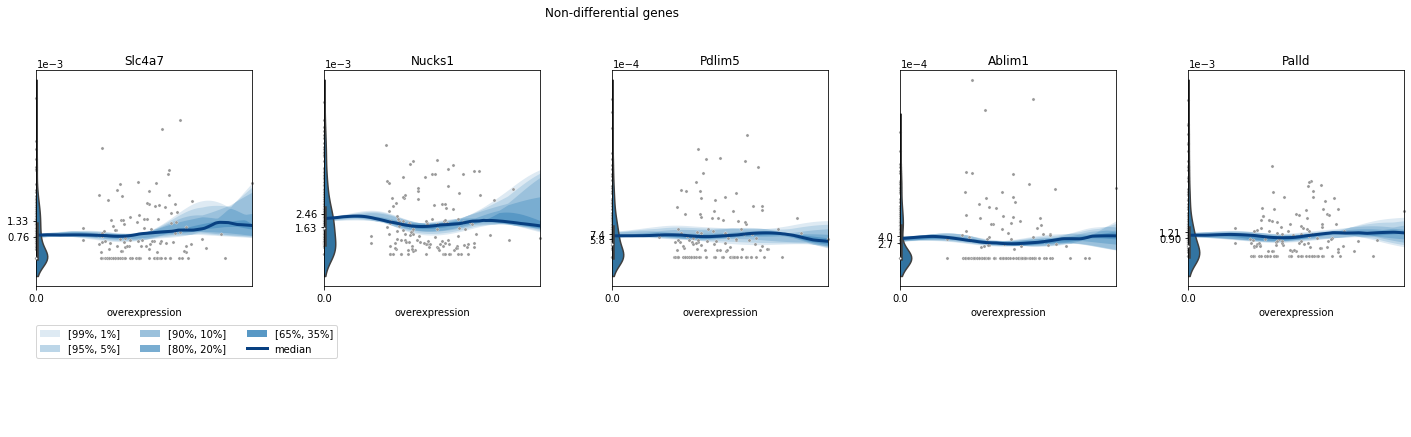

In [35]:
plot = models["spline"]["overexpression_causal"].plot_features(feature_ids = scores.index[:5]);
plot.suptitle("Differential genes")
plot = models["spline"]["overexpression_causal"].plot_features(feature_ids = scores.query("bf > log(10)").index[-5:]);
plot.suptitle("Barely differential genes")
plot = models["spline"]["overexpression_causal"].plot_features(feature_ids = scores.index[-5:]);
plot.suptitle("Non-differential genes")

:::{note}

Working with these different models and posteriors may feel quite cumbersome, with tons of repeated code for each model. We agree! That's why in the next tutorial, you're going to see our approach at making these things easier to scale up and maintaining persistence of models across session.

:::

### Comparing spline and linear

In [36]:
scores = (elbo_genes["spline"] - elbo_genes["linear"]).rename("bf").to_frame()
scores["bf_constant"] = bfs.max(1)
scores = scores.query("bf_constant > log(10)")

In [37]:
scores["symbol"] = adata.var["symbol"][scores.index]
scores = scores.sort_values("bf", ascending = False)
scores

,bf,bf_constant,symbol
gene,,,
ENSMUSG00000026459,106.468235,174.829564,Myog
ENSMUSG00000061723,97.663634,152.918837,Tnnt3
ENSMUSG00000026414,71.495974,141.111073,Tnnt2
ENSMUSG00000017300,65.465999,130.806926,Tnnc2
ENSMUSG00000031097,61.690518,140.566456,Tnni2
...,...,...,...
ENSMUSG00000039542,-10.174401,42.379941,Ncam1
ENSMUSG00000062929,-10.603536,77.004792,Cfl2
ENSMUSG00000029467,-12.134252,92.904561,Atp2a2


In [38]:
nonlinear = scores.query("(bf > log(10))").sort_values("bf_constant", ascending = False)
unclear = scores.query("(bf > log(10)) & (bf < log(30))").sort_values("bf_constant", ascending = False)
linear = scores.query("(bf < log(10))").sort_values("bf_constant", ascending = False)

Text(0.5, 0.98, 'Linear genes')

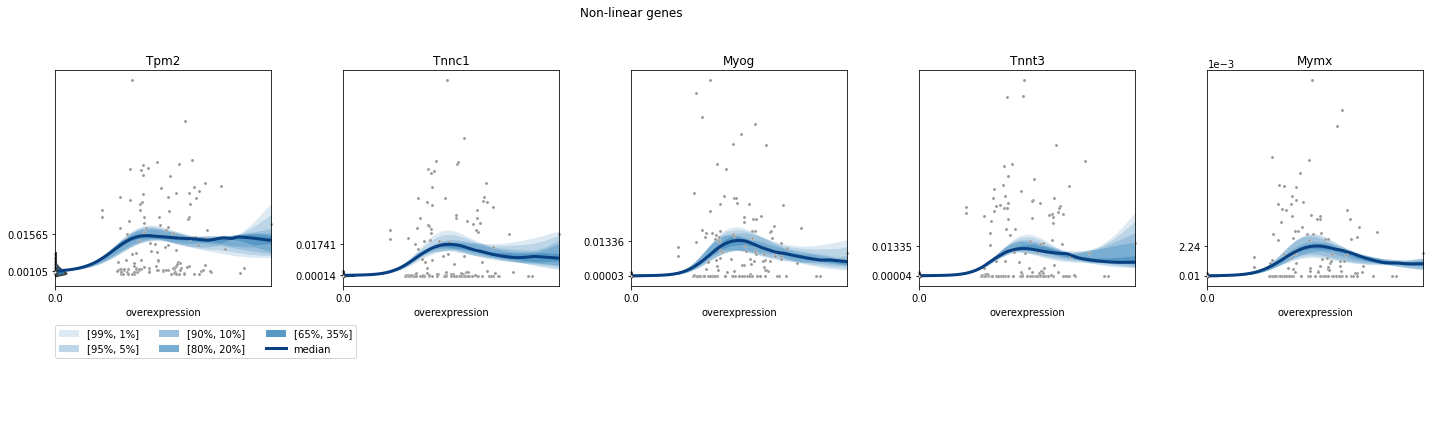

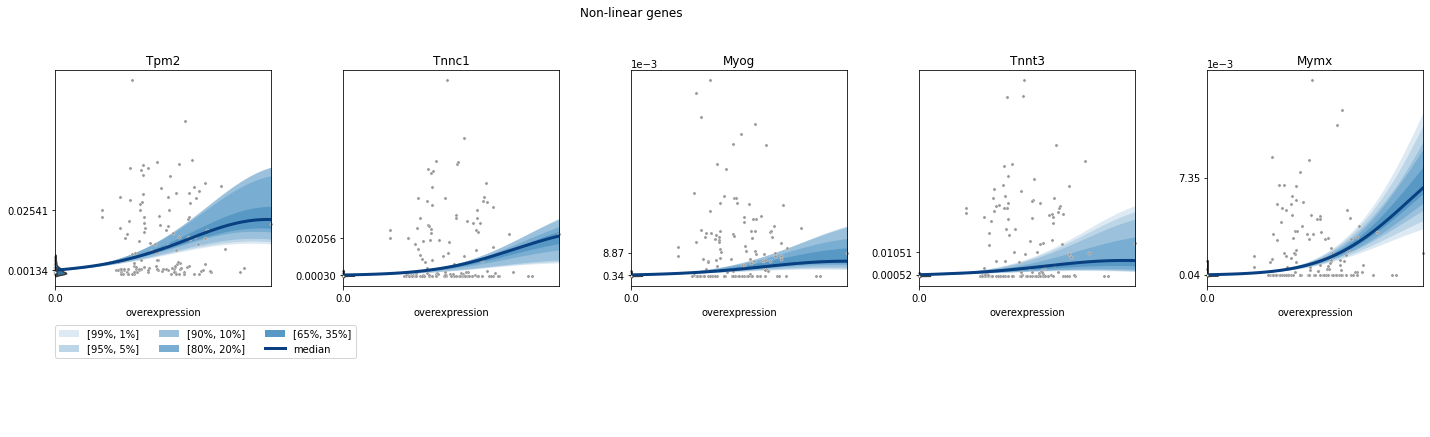

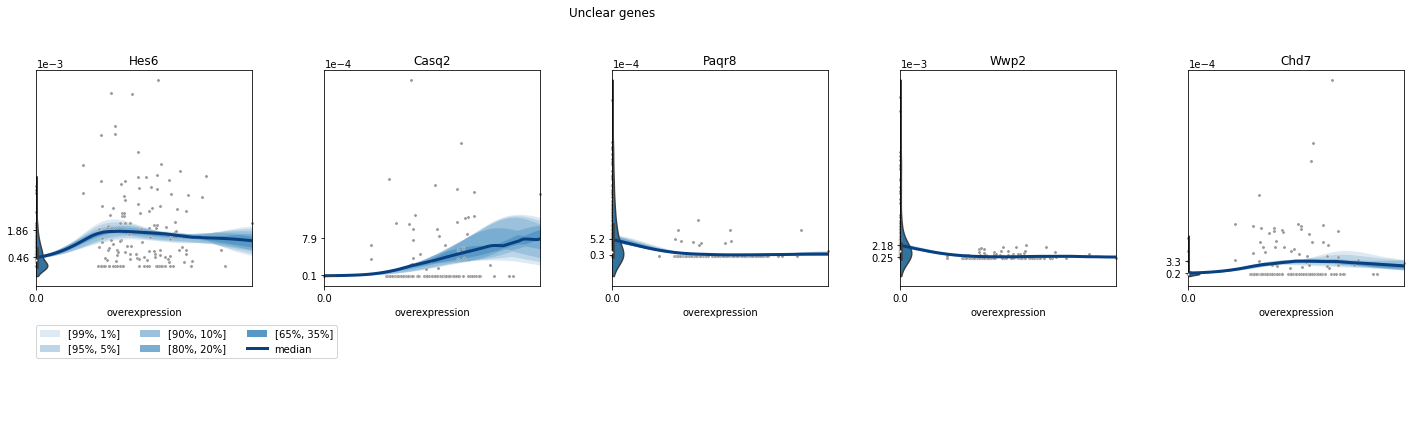

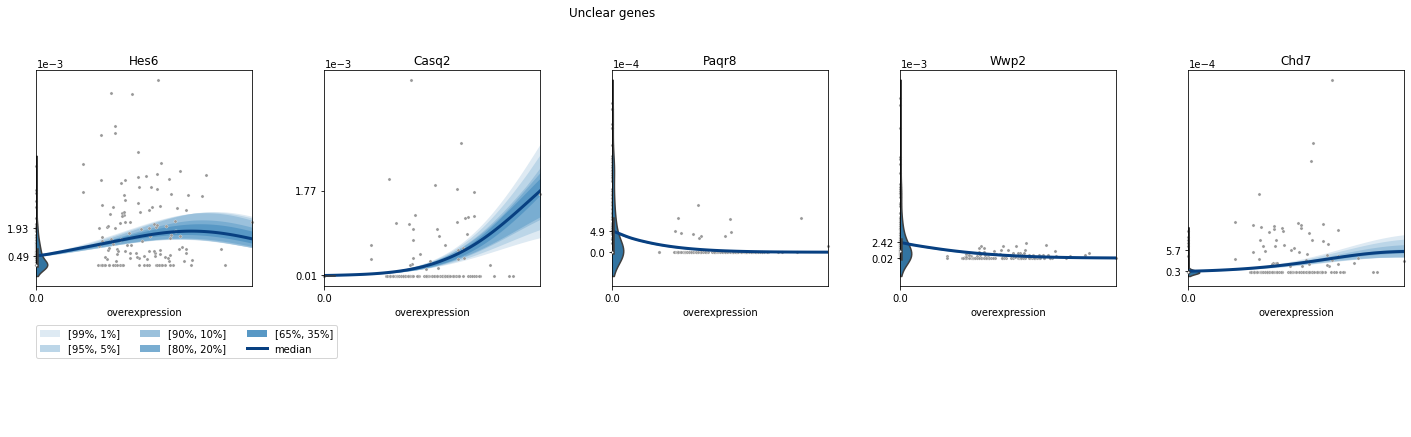

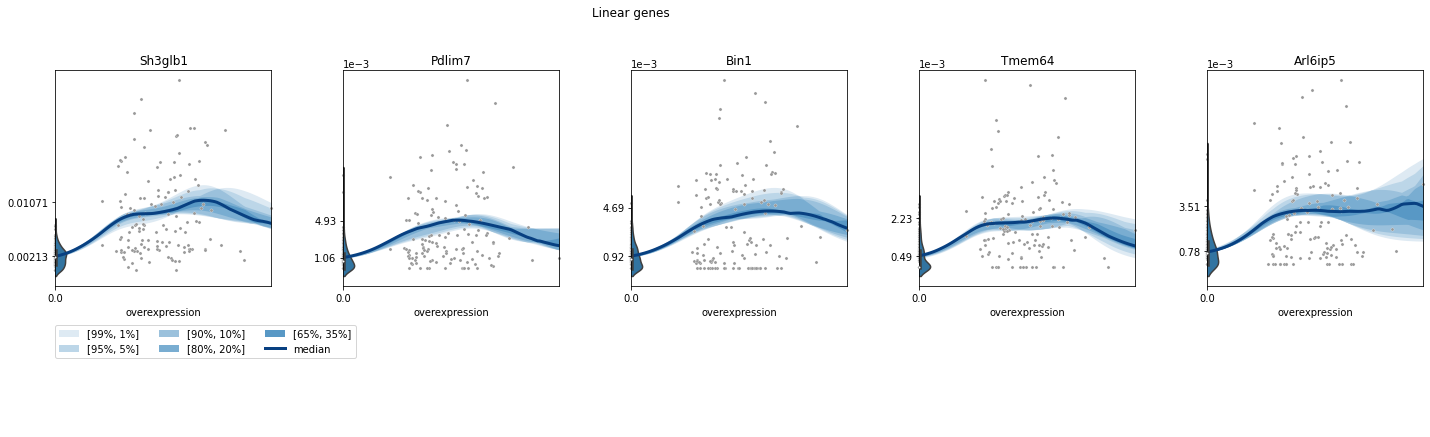

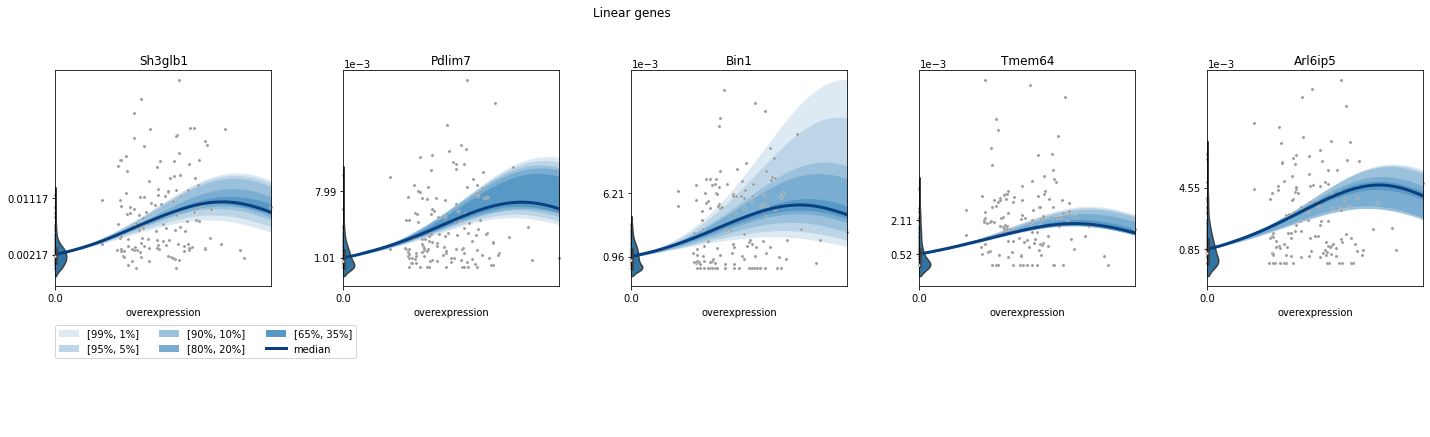

In [39]:
plot = models["spline"]["overexpression_causal"].plot_features(feature_ids = nonlinear.index[:5]);
plot.suptitle("Non-linear genes")
plot = models["linear"]["overexpression_causal"].plot_features(feature_ids = nonlinear.index[:5]);
plot.suptitle("Non-linear genes")

plot = models["spline"]["overexpression_causal"].plot_features(feature_ids = unclear.index[:5]);
plot.suptitle("Unclear genes")
plot = models["linear"]["overexpression_causal"].plot_features(feature_ids = unclear.index[:5]);
plot.suptitle("Unclear genes")


plot = models["spline"]["overexpression_causal"].plot_features(feature_ids = linear.index[:5]);
plot.suptitle("Linear genes")
plot = models["linear"]["overexpression_causal"].plot_features(feature_ids = linear.index[:5]);
plot.suptitle("Linear genes")